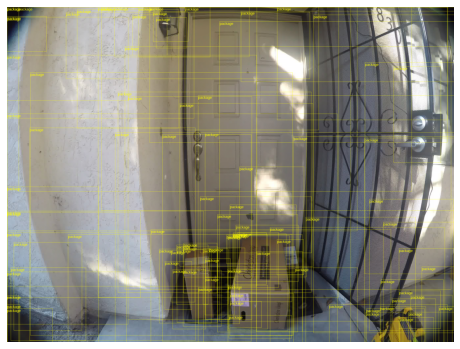

In [1]:
import onnxruntime as rt
import numpy as np
from PIL import Image, ImageDraw, ImageColor, ImageFont
import math
import matplotlib.pyplot as plt
import os
import sys

# params
MODEL = "home/digvijayyadav48/package_detector/tfmodel.onnx"
PROTOTXT = '/home/digvijayyadav48/package_detector/training-temp/digvijayyadav48/confident_leavitt/label_map.txt'
IMAGE = '/home/digvijayyadav48/Downloads/Packages/JPEGImages/gp3_0024.jpg'

# force tf2onnx to cpu
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

# inference session
img = Image.open(IMAGE)
img_data = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)
img_data = np.expand_dims(img_data.astype(np.uint8), axis=0)
sess = rt.InferenceSession(MODEL)
inputs = sess.get_inputs()[0].name
# outputs = sess.get_outputs()[:]
outputs = ["num_detections", "detection_boxes", "detection_scores", "detection_classes"]
result = sess.run(outputs, {inputs: img_data})
num_detections, detection_boxes, detection_scores, detection_classes = result

# draw results
def draw_detection(draw, d, c):
    width, height = draw.im.size
    # the box is relative to the image size so we multiply with height and width to get pixels.
    top = d[0] * height
    left = d[1] * width
    bottom = d[2] * height
    right = d[3] * width
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(height, np.floor(bottom + 0.5).astype('int32'))
    right = min(width, np.floor(right + 0.5).astype('int32'))
    label = coco_classes[c.astype('int32') - 1] # shift to zero element
    label_size = draw.textsize(label)
    text_origin = tuple(np.array([left + 1, top + 1]))
    color = ImageColor.getrgb("yellow")
    thickness = 0
    draw.rectangle([left + thickness, top + thickness, right - thickness, bottom - thickness], outline=color)
    draw.text(text_origin, label, fill=color, font=font)

coco_classes = []

with open(PROTOTXT) as lines:
    for line in lines:
        coco_classes.append(line.strip())

font = ImageFont.truetype("/home/digvijayyadav48/LiberationSans-Regular.ttf", 22)


batch_size = num_detections.shape[0]
draw = ImageDraw.Draw(img)
for batch in range(0, batch_size):
    for detection in range(0, int(num_detections[batch])):
        c = detection_classes[batch][detection]
        d = detection_boxes[batch][detection]
        draw_detection(draw, d, c)
        
# print(detection_scores)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(img)
plt.show()